In [387]:
import pandas as pd
import numpy as np
import string
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import re
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Input, Dense, Flatten, LSTM
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from tensorflow.keras import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import csv

In [406]:
train = pd.read_csv('train_novel.csv')
test = pd.read_csv('test_novel.csv')

train.head()

,input,target
0,"""But u.. WILL knw it, WHEN I TELL YOU WOT happ...","""But you will know it, when I tell you what ha..."
1,Joey: hai! Care TO intro nw?,Joey: Hi! Care to introduce now?
2,Elizabeth's mind wuz nw... relieved fr a veri ...,Elizabeth's mind was now relieved from a very ...
3,Haha.. ok.. So s he handsum or nt? haha.,Haha. ok. So is he handsome or not? haha.
4,ILL Be TRG ON wednesday. Ill kp YOU informed a...,I'll be TRG on Wednesday. I'll keep you inform...


In [407]:
input_lengths = []
target_lengths = []
for i, row in train.iterrows():
  input_lengths.append(len(row['input']))
  target_lengths.append(len(row['target']))


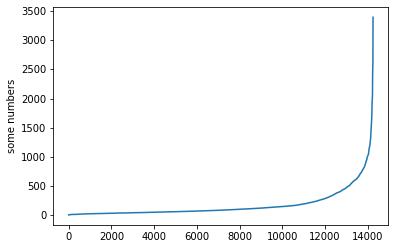

In [408]:
import matplotlib.pyplot as plt
x_value = range(len(input_lengths))
y_value = sorted(input_lengths)
plt.plot(x_value , y_value)
plt.ylabel('some numbers')
plt.show()

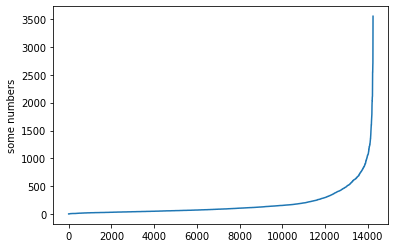

In [409]:
x_value = range(len(target_lengths))
y_value = sorted(target_lengths)
plt.plot(x_value , y_value)
plt.ylabel('some numbers')
plt.show()

In [410]:
train['input_lengths'] = input_lengths
train['target_lengths'] = target_lengths

In [411]:
train = train[train['input_lengths'] < 500]
train = train[train['target_lengths'] < 500]

In [412]:
train = train.drop(['input_lengths', 'target_lengths'], axis=1)


In [413]:
required_chars = []
for char in string.printable:
  if ord(char) > 31 and ord(char) < 126:
    required_chars.append(char)


print(len(required_chars))
print(required_chars)

94
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', ':', ';', '<', '=', '>', '?', '@', '[', '\\', ']', '^', '_', '`', '{', '|', '}', ' ']


In [414]:
# Create a dictionary of chars and index value from 1. 0 is reserved for padding by the tokenizer.
vocabulary = dict()
for i in range(len(required_chars)):
  vocabulary[required_chars[i]] = i+1

In [415]:
# Use \t as Start of Sentence and \n as End of Sentence
vocabulary['\n'] = 95
vocabulary['\t'] = 96

In [416]:
# Characters that were found in train and test set and replaced with the normal english characters.
replacements = {'£':'', 'É': 'E', 'Ñ': 'N', 'Ü': 'U', 'à': 'a', 'ä': 'a', 'å': 'a', 'è': 'e', 'é': 'e', 'ì': 'i', 'ñ': 'n', 'ò': 'o', 'ö': 'o', 'ø': 'o', 'ù': 'u', 'ü': 'u',  '“': '"',  '”': '"',   '，': ',',   '？': '?' }

In [417]:
for old_char, new_char in replacements.items():
  train = train.replace(old_char, new_char, regex=True)
  test = test.replace(old_char, new_char, regex=True)

In [ ]:
# gen_sen_train = []
# target_sen_train = []
# gen_sen_test = []
# target_sen_test = []

# from textblob import TextBlob
# from tqdm import tqdm

# for i, row in tqdm(train.iterrows()):
#     textBlb = TextBlob(row['input'])
#     textCorrected = textBlb.correct() 
#     gen_sen_train.append(str(textCorrected))
#     target_sen_train.append(row['target'])

# for i, row in tqdm(test.iterrows()):
#     textBlb = TextBlob(row['input'])
#     textCorrected = textBlb.correct() 
#     gen_sen_test.append(str(textCorrected))
#     target_sen_test.append(row['target'])


In [ ]:
# train = pd.DataFrame({
#     'input':gen_sen_train,
#     'target':target_sen_train
# })

# test = pd.DataFrame({
#     'input':gen_sen_test,
#     'target':target_sen_test
# })

In [418]:
train['input'] = train['input'].replace({'..':'.', '...':'.', '???':'?', '??':'?', '#':'', "!!":"!","!!!":"!","@":"","$":"","%":"","^":"","&":"","(":"",")":"","_":"", ";":""})

In [419]:
for i, row in train.iterrows():
    value = row['input']
    repl_value = re.sub(r'\.+', ".", value)
    repl_value = re.sub(r'\!+', "!", repl_value)
    repl_value = re.sub(r'\ +', " ", repl_value)
    train.at[i,'input'] = repl_value

for i, row in test.iterrows():
    value = row['input']
    repl_value = re.sub(r'\.+', ".", value)
    repl_value = re.sub(r'\!+', "!", repl_value)
    repl_value = re.sub(r'\ +', " ", repl_value)
    test.at[i,'input'] = repl_value

In [420]:
train.head()

,input,target
0,"""But u. WILL knw it, WHEN I TELL YOU WOT happe...","""But you will know it, when I tell you what ha..."
1,Joey: hai! Care TO intro nw?,Joey: Hi! Care to introduce now?
2,Elizabeth's mind wuz nw. relieved fr a veri he...,Elizabeth's mind was now relieved from a very ...
3,Haha. ok. So s he handsum or nt? haha.,Haha. ok. So is he handsome or not? haha.
4,ILL Be TRG ON wednesday. Ill kp YOU informed a...,I'll be TRG on Wednesday. I'll keep you inform...


In [421]:
# Adding the \t and \n as part of start and end of sentence
train['target_ip'] = '\t' + train['target'].astype(str)
train['target_op'] =  train['target'].astype(str) + '\n'

test['target_ip'] = '\t' + test['target'].astype(str)
test['target_op'] =  test['target'].astype(str) + '\n'

In [422]:
train = train.drop(['target'], axis=1)
test = test.drop(['target'], axis=1)

In [423]:
train.head()

,input,target_ip,target_op
0,"""But u. WILL knw it, WHEN I TELL YOU WOT happe...","\t""But you will know it, when I tell you what ...","""But you will know it, when I tell you what ha..."
1,Joey: hai! Care TO intro nw?,\tJoey: Hi! Care to introduce now?,Joey: Hi! Care to introduce now?\n
2,Elizabeth's mind wuz nw. relieved fr a veri he...,\tElizabeth's mind was now relieved from a ver...,Elizabeth's mind was now relieved from a very ...
3,Haha. ok. So s he handsum or nt? haha.,\tHaha. ok. So is he handsome or not? haha.,Haha. ok. So is he handsome or not? haha.\n
4,ILL Be TRG ON wednesday. Ill kp YOU informed a...,\tI'll be TRG on Wednesday. I'll keep you info...,I'll be TRG on Wednesday. I'll keep you inform...


In [424]:
train.iloc[0]['target_ip']= str(train.iloc[0]['target_ip'])+'\n'
train.iloc[0]['target_op']= str(train.iloc[0]['target_op'])+'\n'

In [425]:
# Calculating the maximum length of among all the sentences which will be useful for padding.
max_length_encoder = train['input'].map(len).max()

print(max_length_encoder)

480


In [426]:
max_length_decoder = max( train['target_ip'].map(len).max(), train['target_op'].map(len).max())
print(max_length_decoder)

499


In [427]:
# Tokenizer for the raw input and target output
tokenizer_raw_ip = Tokenizer(
    char_level=True,
    lower=False,
    filters=None
)

tokenizer_target_ip = Tokenizer(
    char_level=True,
    lower=False,
    filters=None
)

In [428]:
tokenizer_raw_ip.fit_on_texts(train['input'].values)
tokenizer_target_ip.fit_on_texts(train['target_ip'].values)

In [429]:
# Replacing the vocabulary of the trained index to a vocabulary mentioned in the research paper
tokenizer_target_ip.word_index = vocabulary
tokenizer_raw_ip.word_index = vocabulary

In [430]:
target_vocab_size=len(tokenizer_target_ip.word_index.keys())
print(target_vocab_size)
input_vocab_size=len(tokenizer_raw_ip.word_index.keys())
print(input_vocab_size)

96
96


In [431]:
# Encoder class with Embedding layer and LSTM layer.
class Encoder(tf.keras.layers.Layer):
    def __init__(self, vocab_size, embedding_dim, input_length, enc_units):
        super().__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.input_length = input_length
        self.enc_units= enc_units
        self.lstm_output = 0
        self.lstm_state_h=0
        self.lstm_state_c=0
        
    def build(self, input_shape):
        self.embedding = Embedding(input_dim=self.vocab_size, output_dim=self.embedding_dim, input_length=self.input_length, mask_zero=True, name="Embedding_Layer_Encoder")
        self.lstm = LSTM(self.enc_units, return_state=True, name="Encoder_LSTM")
        
    def call(self, input_sentances, training=True):
        
        input_embedded = self.embedding(input_sentances)
        self.lstm_output, self.lstm_state_h,self.lstm_state_c = self.lstm(input_embedded)
        return self.lstm_output, self.lstm_state_h,self.lstm_state_c

    def get_states(self):
        return self.lstm_state_h,self.lstm_state_c
    
# Decoder class with embedding and LSTM layer.    
class Decoder(tf.keras.layers.Layer):
    def __init__(self, vocab_size, embedding_dim, input_length, dec_units):
        super().__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.dec_units = dec_units
        self.input_length = input_length
        # we are using embedding_matrix and not training the embedding layer
        self.embedding = Embedding(input_dim=self.vocab_size, output_dim=self.embedding_dim, input_length=self.input_length, mask_zero=True, name="Embedding_Layer_Decoder",)
        self.lstm = LSTM(self.dec_units, return_sequences=True, return_state=True, name="Decoder_LSTM")
    
    def call(self, target_sentences, state_h, state_c):
        target_embedded           = self.embedding(target_sentences)
        lstm_output, _,_        = self.lstm(target_embedded, initial_state=[state_h, state_c])
        return lstm_output

In [432]:
# Creating a data pipeline
class Dataset:
    def __init__(self, data, tokenizer_raw_ip, tokenizer_target_ip, max_length_encoder,max_length_decoder):
        self.encoder_inps = data['input'].values
        self.decoder_inps = data['target_ip'].values
        self.decoder_outs = data['target_op'].values
        self.tokenizer_target_ip = tokenizer_target_ip
        self.tokenizer_raw_ip = tokenizer_raw_ip
        self.max_length_encoder = max_length_encoder
        self.max_length_decoder = max_length_decoder

    def __getitem__(self, i):
        self.encoder_seq = self.tokenizer_raw_ip.texts_to_sequences([self.encoder_inps[i]]) # need to pass list of values
        self.decoder_inp_seq = self.tokenizer_target_ip.texts_to_sequences([self.decoder_inps[i]])
        self.decoder_out_seq = self.tokenizer_target_ip.texts_to_sequences([self.decoder_outs[i]])

        self.encoder_seq = pad_sequences(self.encoder_seq, maxlen=self.max_length_encoder, dtype='int32', padding='post')
        self.decoder_inp_seq = pad_sequences(self.decoder_inp_seq, maxlen=self.max_length_decoder, dtype='int32', padding='post')
        self.decoder_out_seq = pad_sequences(self.decoder_out_seq, maxlen=self.max_length_decoder, dtype='int32', padding='post')
        return self.encoder_seq, self.decoder_inp_seq, self.decoder_out_seq

    def __len__(self): # your model.fit_gen requires this function
        return len(self.encoder_inps)

    
class Dataloder(tf.keras.utils.Sequence):    
    def __init__(self, dataset, batch_size=1):
        self.dataset = dataset
        self.batch_size = batch_size
        self.indexes = np.arange(len(self.dataset.encoder_inps))


    def __getitem__(self, i):
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])

        batch = [np.squeeze(np.stack(samples, axis=1), axis=0) for samples in zip(*data)]
        # we are creating data like ([italian, english_inp], english_out) these are already converted into seq
        return tuple([[batch[0],batch[1]],batch[2]])

    def __len__(self):  # your model.fit_gen requires this function
        return len(self.indexes) // self.batch_size

    def on_epoch_end(self):
        self.indexes = np.random.permutation(self.indexes)

In [433]:
train_dataset = Dataset(train, tokenizer_raw_ip, tokenizer_target_ip, max_length_encoder, max_length_decoder)
test_dataset  = Dataset(test, tokenizer_raw_ip, tokenizer_target_ip, max_length_encoder, max_length_decoder)

train_dataloader = Dataloder(train_dataset, batch_size=64)
test_dataloader = Dataloder(test_dataset, batch_size=20)

print(train_dataloader[1][0][0].shape, train_dataloader[0][0][1].shape, train_dataloader[0][1].shape)

(64, 480) (64, 499) (64, 499)


In [434]:
test_dataloader[0][0][0].shape

(20, 480)

In [436]:
# Model 1 - 1 layer LSTM model for each encoder and decoder
class Model1(Model):
    def __init__(self, encoder_inputs_length,decoder_inputs_length, output_vocab_size):
        super().__init__() # https://stackoverflow.com/a/27134600/4084039
        self.encoder = Encoder(vocab_size=input_vocab_size+1, embedding_dim=50, input_length=encoder_inputs_length, enc_units=500)
        self.decoder = Decoder(vocab_size=target_vocab_size+1, embedding_dim=50, input_length=decoder_inputs_length, dec_units=500)
        self.dense   = Dense(output_vocab_size, activation='softmax')
        
    def call(self, data):
        input,output = data[0], data[1]
        encoder_output, encoder_h, encoder_c = self.encoder(input)
        decoder_output                       = self.decoder(output, encoder_h, encoder_c)
        output                               = self.dense(decoder_output)
        return output        

In [437]:
# Reduce learning rate based on the validation loss
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.8, verbose=1, mode='min', min_lr=0.001)

In [438]:
checkpoint_filepath = 'model_1'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

In [443]:
model  = Model1(encoder_inputs_length=max_length_encoder,decoder_inputs_length=max_length_decoder,output_vocab_size=target_vocab_size)

In [444]:
# Do once normal loss function works
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def custom_lossfunction(real, pred):

  # Custom loss function that will not consider the loss for padded zeros.
  # Refer https://www.tensorflow.org/tutorials/text/nmt_with_attention#define_the_optimizer_and_the_loss_function
  
  loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)


In [445]:
# Using Adam and Gradient clipping to prevent gradient explosion as mentioned in the research paper
optimizer = tf.keras.optimizers.Adam(lr=0.001)
model.compile(optimizer=optimizer,loss='sparse_categorical_crossentropy')
train_steps=train.shape[0]//64
valid_steps=test.shape[0]//20 


In [446]:
model.fit(train_dataloader, steps_per_epoch=train_steps, epochs=20,  validation_data=test_dataloader, validation_steps=valid_steps, callbacks=[reduce_lr, model_checkpoint_callback])
model.summary()

Epoch 1/20
203/203 [==============================] - 34s 140ms/step - loss: 0.7440 - val_loss: 0.2410
Epoch 2/20
203/203 [==============================] - 26s 130ms/step - loss: 0.5362 - val_loss: 0.2081
Epoch 3/20
203/203 [==============================] - 26s 130ms/step - loss: 0.4630 - val_loss: 0.1861
Epoch 4/20
203/203 [==============================] - 26s 130ms/step - loss: 0.4239 - val_loss: 0.1711
Epoch 5/20
203/203 [==============================] - 27s 130ms/step - loss: 0.3785 - val_loss: 0.1600
Epoch 6/20
203/203 [==============================] - 26s 130ms/step - loss: 0.3556 - val_loss: 0.1518
Epoch 7/20
203/203 [==============================] - 27s 131ms/step - loss: 0.3311 - val_loss: 0.1462
Epoch 8/20
203/203 [==============================] - 27s 131ms/step - loss: 0.3175 - val_loss: 0.1413
Epoch 9/20
203/203 [==============================] - 26s 130ms/step - loss: 0.3002 - val_loss: 0.1393
Epoch 10/20
203/203 [==============================] - 26s 130ms/step - l

In [447]:
model.load_weights("model_1")

In [448]:
model.evaluate(test_dataloader)

1/1 [==============================] - 0s 49ms/step - loss: 0.1359


0.13589681684970856

In [449]:
model.save_weights('./model_1/model_novel_1')

In [450]:
print("The validation loss of the model 1 is:", 0.1359)
print("The perplexity of the model 1 is:", 2**(0.1359))

The validation loss of the model 1 is: 0.1359
The perplexity of the model 1 is: 1.0987780534462817


In [451]:
start_index = tokenizer_target_ip.word_index['\t']
end_index = tokenizer_target_ip.word_index['\n']
DECODER_SEQ_LEN = max_length_decoder
max_len = max_length_decoder


def predict(input_sentence):

  encoder_seq = tokenizer_raw_ip.texts_to_sequences([input_sentence])

  encoder_seq = pad_sequences(encoder_seq, maxlen=max_length_encoder, dtype='int32', padding='post')

  enc_output, enc_state_h, enc_state_c = model.layers[0](encoder_seq)

  dec_input = np.zeros((1, 1))

  # Start of sentence
  dec_input[0][0] = tokenizer_target_ip.word_index['\t']

  input_state = [enc_state_h, enc_state_c]

  output_word = []

  for i in range(DECODER_SEQ_LEN):
      cur_emb = model.layers[1].embedding(dec_input)

      predicted_out, state_h, state_c = model.layers[1].lstm(cur_emb, input_state)

      dense_layer_out = model.layers[2](predicted_out)

      input_state = [state_h, state_c]
  
      output_word_index = np.argmax(dense_layer_out)

      # print(output_word_index)

      for key, value in tokenizer_target_ip.word_index.items():

         if output_word_index == value:
             output_word.append(key)

      dec_input = np.reshape(output_word_index, (1, 1))

      if dec_input == tokenizer_target_ip.word_index['\n']:
        break
  return output_word


In [452]:
predicted_sentences = []
actual_sentences = []

for i, row in test.iterrows():
    output = predict(row['input'])
    predicted_sentences.append(output)
    english_out = row['target_op'].split()
    actual_sentences.append(english_out)
    sentence = ''.join(output)
    print('Input Sentence:',row['input'])
    print('Predicted Sentence:',sentence)
    print('Original English sentence:', row['target_op'])
    print('*'*30)

Input Sentence: Mmm thats better now i got a roast down me! i'd b better if i had a few drinks down me 2! Good indian?
Predicted Sentence: My dear the good and the best then I will be late. I will be late. I will be late. I will be late. I will be late.

Original English sentence: That's better now, I got a roast down me! I'd be better if I had a few drinks down me too! Good Indian?

******************************
Input Sentence: Watch wat?
Predicted Sentence: What are you?

Original English sentence: Watch what?

******************************
Input Sentence: Oh dat.hehe.Why r u so interested?
Predicted Sentence: Oh. I don't know where to go to see you?

Original English sentence: Oh that. Hehe. Why are you so interested?

******************************
Input Sentence: hai
Predicted Sentence: Ok.

Original English sentence: Hi.

******************************
Input Sentence: ask more abt me?
Predicted Sentence: Joey: Hi! Have you doing?

Original English sentence: Ask more about me?



In [453]:
from nltk.translate.bleu_score import sentence_bleu
avg_score = 0
for i in range(len(actual_sentences)):
    score = sentence_bleu([actual_sentences[i]], predicted_sentences[i])
    avg_score += score

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [454]:
print("Avg BLEU Score of Simple Encoder Decoder Model:", (avg_score/(len(actual_sentences))))

Avg BLEU Score of Simple Encoder Decoder Model: 0.09185575759054612


# Model 2 - 2 layer - Char embedding

In [455]:
train = pd.read_csv('train_novel.csv')
test = pd.read_csv('test_novel.csv')

train.head()

,input,target
0,"""But u.. WILL knw it, WHEN I TELL YOU WOT happ...","""But you will know it, when I tell you what ha..."
1,Joey: hai! Care TO intro nw?,Joey: Hi! Care to introduce now?
2,Elizabeth's mind wuz nw... relieved fr a veri ...,Elizabeth's mind was now relieved from a very ...
3,Haha.. ok.. So s he handsum or nt? haha.,Haha. ok. So is he handsome or not? haha.
4,ILL Be TRG ON wednesday. Ill kp YOU informed a...,I'll be TRG on Wednesday. I'll keep you inform...


In [456]:
input_lengths = []
target_lengths = []
for i, row in train.iterrows():
  input_lengths.append(len(row['input']))
  target_lengths.append(len(row['target']))


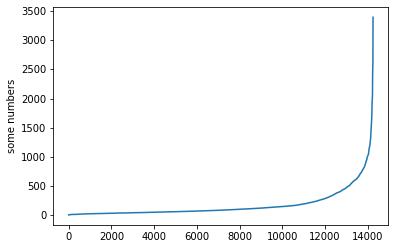

In [457]:
import matplotlib.pyplot as plt
x_value = range(len(input_lengths))
y_value = sorted(input_lengths)
plt.plot(x_value , y_value)
plt.ylabel('some numbers')
plt.show()

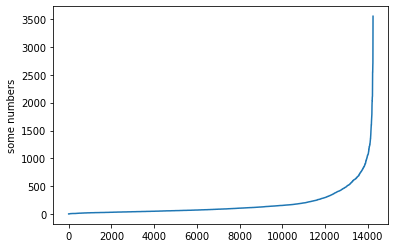

In [458]:
x_value = range(len(target_lengths))
y_value = sorted(target_lengths)
plt.plot(x_value , y_value)
plt.ylabel('some numbers')
plt.show()

In [459]:
train['input_lengths'] = input_lengths
train['target_lengths'] = target_lengths

In [460]:
train = train[train['input_lengths'] < 500]
train = train[train['target_lengths'] < 500]

In [461]:
train = train.drop(['input_lengths', 'target_lengths'], axis=1)


In [462]:
required_chars = []
for char in string.printable:
  if ord(char) > 31 and ord(char) < 126:
    required_chars.append(char)


print(len(required_chars))
print(required_chars)

94
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', ':', ';', '<', '=', '>', '?', '@', '[', '\\', ']', '^', '_', '`', '{', '|', '}', ' ']


In [463]:
# Create a dictionary of chars and index value from 1. 0 is reserved for padding by the tokenizer.
vocabulary = dict()
for i in range(len(required_chars)):
  vocabulary[required_chars[i]] = i+1

In [464]:
# Use \t as Start of Sentence and \n as End of Sentence
vocabulary['\n'] = 95
vocabulary['\t'] = 96

In [465]:
# Characters that were found in train and test set and replaced with the normal english characters.
replacements = {'£':'', 'É': 'E', 'Ñ': 'N', 'Ü': 'U', 'à': 'a', 'ä': 'a', 'å': 'a', 'è': 'e', 'é': 'e', 'ì': 'i', 'ñ': 'n', 'ò': 'o', 'ö': 'o', 'ø': 'o', 'ù': 'u', 'ü': 'u',  '“': '"',  '”': '"',   '，': ',',   '？': '?' }

In [466]:
for old_char, new_char in replacements.items():
  train = train.replace(old_char, new_char, regex=True)
  test = test.replace(old_char, new_char, regex=True)

In [467]:
train['input'] = train['input'].replace({'..':'.', '...':'.', '???':'?', '??':'?', '#':'', "!!":"!","!!!":"!","@":"","$":"","%":"","^":"","&":"","(":"",")":"","_":"", ";":""})

In [468]:
for i, row in train.iterrows():
    value = row['input']
    repl_value = re.sub(r'\.+', ".", value)
    repl_value = re.sub(r'\!+', "!", repl_value)
    repl_value = re.sub(r'\ +', " ", repl_value)
    train.at[i,'input'] = repl_value

for i, row in test.iterrows():
    value = row['input']
    repl_value = re.sub(r'\.+', ".", value)
    repl_value = re.sub(r'\!+', "!", repl_value)
    repl_value = re.sub(r'\ +', " ", repl_value)
    test.at[i,'input'] = repl_value

In [469]:
train.head()

,input,target
0,"""But u. WILL knw it, WHEN I TELL YOU WOT happe...","""But you will know it, when I tell you what ha..."
1,Joey: hai! Care TO intro nw?,Joey: Hi! Care to introduce now?
2,Elizabeth's mind wuz nw. relieved fr a veri he...,Elizabeth's mind was now relieved from a very ...
3,Haha. ok. So s he handsum or nt? haha.,Haha. ok. So is he handsome or not? haha.
4,ILL Be TRG ON wednesday. Ill kp YOU informed a...,I'll be TRG on Wednesday. I'll keep you inform...


In [470]:
# Adding the \t and \n as part of start and end of sentence
train['target_ip'] = '\t' + train['target'].astype(str)
train['target_op'] =  train['target'].astype(str) + '\n'

test['target_ip'] = '\t' + test['target'].astype(str)
test['target_op'] =  test['target'].astype(str) + '\n'

In [471]:
train = train.drop(['target'], axis=1)
test = test.drop(['target'], axis=1)

In [472]:
train.head()

,input,target_ip,target_op
0,"""But u. WILL knw it, WHEN I TELL YOU WOT happe...","\t""But you will know it, when I tell you what ...","""But you will know it, when I tell you what ha..."
1,Joey: hai! Care TO intro nw?,\tJoey: Hi! Care to introduce now?,Joey: Hi! Care to introduce now?\n
2,Elizabeth's mind wuz nw. relieved fr a veri he...,\tElizabeth's mind was now relieved from a ver...,Elizabeth's mind was now relieved from a very ...
3,Haha. ok. So s he handsum or nt? haha.,\tHaha. ok. So is he handsome or not? haha.,Haha. ok. So is he handsome or not? haha.\n
4,ILL Be TRG ON wednesday. Ill kp YOU informed a...,\tI'll be TRG on Wednesday. I'll keep you info...,I'll be TRG on Wednesday. I'll keep you inform...


In [473]:
train.iloc[0]['target_ip']= str(train.iloc[0]['target_ip'])+'\n'
train.iloc[0]['target_op']= str(train.iloc[0]['target_op'])+'\n'

In [474]:
# Calculating the maximum length of among all the sentences which will be useful for padding.
max_length_encoder = train['input'].map(len).max()

print(max_length_encoder)

480


In [475]:
max_length_decoder = max( train['target_ip'].map(len).max(), train['target_op'].map(len).max())
print(max_length_decoder)

499


In [476]:
# Tokenizer for the raw input and target output
tokenizer_raw_ip = Tokenizer(
    char_level=True,
    lower=False,
    filters=None
)

tokenizer_target_ip = Tokenizer(
    char_level=True,
    lower=False,
    filters=None
)

In [477]:
tokenizer_raw_ip.fit_on_texts(train['input'].values)
tokenizer_target_ip.fit_on_texts(train['target_ip'].values)

In [478]:
# Replacing the vocabulary of the trained index to a vocabulary mentioned in the research paper
tokenizer_target_ip.word_index = vocabulary
tokenizer_raw_ip.word_index = vocabulary

In [479]:
target_vocab_size=len(tokenizer_target_ip.word_index.keys())
print(target_vocab_size)
input_vocab_size=len(tokenizer_raw_ip.word_index.keys())
print(input_vocab_size)

96
96


In [480]:
# Encoder class with Embedding layer and 2 LSTM layers.
class Encoder_2_Layer(tf.keras.layers.Layer):
    def __init__(self, vocab_size, embedding_dim, input_length, enc_units):
        super().__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.input_length = input_length
        self.enc_units= enc_units
        self.lstm_output = 0
        self.lstm_state_h=0
        self.lstm_state_c=0
        
    def build(self, input_shape):
        self.embedding = Embedding(input_dim=self.vocab_size, output_dim=self.embedding_dim, input_length=self.input_length,
                           mask_zero=True, name="embedding_layer_encoder")
        self.lstm_1 = LSTM(self.enc_units, return_state=True, return_sequences=True, name="Encoder_LSTM_1")
        self.lstm_2 = LSTM(self.enc_units, return_state=True, return_sequences=True, name="Encoder_LSTM_2")
        
    def call(self, input_sentences, training=True):
        input_embedded                           = self.embedding(input_sentences)
        self.lstm_output_1, lstm_state_h_1,self.lstm_state_c_1 = self.lstm_1(input_embedded)
        self.lstm_output_2, self.lstm_state_h_2,self.lstm_state_c_2 = self.lstm_2(self.lstm_output_1)

        return  self.lstm_output_1, lstm_state_h_1, self.lstm_state_c_1, self.lstm_output_2, self.lstm_state_h_2, self.lstm_state_c_2
        
    def get_states(self):
        return self.lstm_state_h, self.lstm_state_c
    
# Decoder class with Embedding layer and 2 LSTM layers.    
class Decoder_2_Layer(tf.keras.layers.Layer):
    def __init__(self, vocab_size, embedding_dim, input_length, dec_units):
        super().__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.dec_units = dec_units
        self.input_length = input_length
        # we are using embedding_matrix and not training the embedding layer
        self.embedding = Embedding(input_dim=self.vocab_size, output_dim=self.embedding_dim, input_length=self.input_length,
                           mask_zero=True, name="embedding_layer_decoder",)
        self.lstm_1 = LSTM(self.dec_units, return_sequences=True, return_state=True, name="Decoder_LSTM_1")
        self.lstm_2 = LSTM(self.dec_units, return_sequences=True, return_state=True, name="Decoder_LSTM_2")
    
    def call(self, target_sentances, state_h_1, state_c_1, state_h_2, state_c_2):
        target_embedd           = self.embedding(target_sentances)
        lstm_output_1, decoder_state_h_1, decoder_state_c_1      = self.lstm_1(target_embedd, initial_state=[state_h_1, state_c_1])
        lstm_output, _,_        = self.lstm_2(lstm_output_1, initial_state=[state_h_2, state_c_2])
        return lstm_output

In [481]:
# Creating a data pipeline
class Dataset:
    def __init__(self, data, tokenizer_raw_ip, tokenizer_target_ip, max_length_encoder,max_length_decoder):
        self.encoder_inps = data['input'].values
        self.decoder_inps = data['target_ip'].values
        self.decoder_outs = data['target_op'].values
        self.tokenizer_target_ip = tokenizer_target_ip
        self.tokenizer_raw_ip = tokenizer_raw_ip
        self.max_length_encoder = max_length_encoder
        self.max_length_decoder = max_length_decoder

    def __getitem__(self, i):
        self.encoder_seq = self.tokenizer_raw_ip.texts_to_sequences([self.encoder_inps[i]]) # need to pass list of values
        self.decoder_inp_seq = self.tokenizer_target_ip.texts_to_sequences([self.decoder_inps[i]])
        self.decoder_out_seq = self.tokenizer_target_ip.texts_to_sequences([self.decoder_outs[i]])

        self.encoder_seq = pad_sequences(self.encoder_seq, maxlen=self.max_length_encoder, dtype='int32', padding='post')
        self.decoder_inp_seq = pad_sequences(self.decoder_inp_seq, maxlen=self.max_length_decoder, dtype='int32', padding='post')
        self.decoder_out_seq = pad_sequences(self.decoder_out_seq, maxlen=self.max_length_decoder, dtype='int32', padding='post')
        return self.encoder_seq, self.decoder_inp_seq, self.decoder_out_seq

    def __len__(self): # your model.fit_gen requires this function
        return len(self.encoder_inps)

    
class Dataloder(tf.keras.utils.Sequence):    
    def __init__(self, dataset, batch_size=1):
        self.dataset = dataset
        self.batch_size = batch_size
        self.indexes = np.arange(len(self.dataset.encoder_inps))


    def __getitem__(self, i):
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])

        batch = [np.squeeze(np.stack(samples, axis=1), axis=0) for samples in zip(*data)]
        # we are creating data like ([italian, english_inp], english_out) these are already converted into seq
        return tuple([[batch[0],batch[1]],batch[2]])

    def __len__(self):  # your model.fit_gen requires this function
        return len(self.indexes) // self.batch_size

    def on_epoch_end(self):
        self.indexes = np.random.permutation(self.indexes)

In [482]:
train_dataset = Dataset(train, tokenizer_raw_ip, tokenizer_target_ip, max_length_encoder, max_length_decoder)
test_dataset  = Dataset(test, tokenizer_raw_ip, tokenizer_target_ip, max_length_encoder, max_length_decoder)

train_dataloader = Dataloder(train_dataset, batch_size=64)
test_dataloader = Dataloder(test_dataset, batch_size=20)


print(train_dataloader[0][0][0].shape, train_dataloader[0][0][1].shape, train_dataloader[0][1].shape)

(64, 480) (64, 499) (64, 499)


In [483]:
input_vocab_size=len(tokenizer_raw_ip.word_index.keys())
print(input_vocab_size)
target_vocab_size=len(tokenizer_target_ip.word_index.keys())
print(target_vocab_size)

96
96


In [496]:
# Model 2 - 2 layer LSTM model for each encoder and decoder
class Model2(Model):
    def __init__(self, encoder_inputs_length,decoder_inputs_length, output_vocab_size):
        super().__init__()
        self.encoder = Encoder_2_Layer(vocab_size=input_vocab_size+1, embedding_dim=50, input_length=encoder_inputs_length, enc_units=200)
        self.decoder = Decoder_2_Layer(vocab_size=target_vocab_size+1, embedding_dim=50, input_length=decoder_inputs_length, dec_units=200)
        self.dense   = Dense(output_vocab_size, activation='softmax')
        
        
    def call(self, data):
        input,output = data[0], data[1]
        encoder_output_1, encoder_h_1, encoder_c_1, encoder_output_2, encoder_h_2, encoder_c_2 = self.encoder(input)
        decoder_output                       = self.decoder(output, encoder_h_1, encoder_c_1, encoder_h_2, encoder_c_2)
        output                               = self.dense(decoder_output)
        return output

In [497]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.9, min_lr=0.0001, verbose=1)

In [498]:
checkpoint_filepath = 'model_2'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

In [499]:
model  = Model2(encoder_inputs_length=max_length_encoder, decoder_inputs_length=max_length_decoder, output_vocab_size=target_vocab_size)
optimizer = tf.keras.optimizers.Adam(lr=0.001)
model.compile(optimizer=optimizer,loss='sparse_categorical_crossentropy')
train_steps=train.shape[0]//64
valid_steps=test.shape[0]//20

In [500]:
model.fit(train_dataloader, steps_per_epoch=train_steps, epochs=50, callbacks=[reduce_lr, model_checkpoint_callback], validation_data=test_dataloader, validation_steps=valid_steps)
model.summary()

Epoch 1/50
203/203 [==============================] - 40s 135ms/step - loss: 0.7707 - val_loss: 0.2870
Epoch 2/50
203/203 [==============================] - 24s 117ms/step - loss: 0.6174 - val_loss: 0.2407
Epoch 3/50
203/203 [==============================] - 24s 117ms/step - loss: 0.5426 - val_loss: 0.2217
Epoch 4/50
203/203 [==============================] - 24s 118ms/step - loss: 0.5011 - val_loss: 0.2095
Epoch 5/50
203/203 [==============================] - 24s 118ms/step - loss: 0.4726 - val_loss: 0.1961
Epoch 6/50
203/203 [==============================] - 24s 117ms/step - loss: 0.4449 - val_loss: 0.1849
Epoch 7/50
203/203 [==============================] - 24s 117ms/step - loss: 0.4288 - val_loss: 0.1757
Epoch 8/50
203/203 [==============================] - 24s 117ms/step - loss: 0.4050 - val_loss: 0.1694
Epoch 9/50
203/203 [==============================] - 24s 117ms/step - loss: 0.3910 - val_loss: 0.1637
Epoch 10/50
203/203 [==============================] - 24s 117ms/step - l

In [501]:
model.load_weights("model_2")

In [502]:
model.evaluate(test_dataloader)

1/1 [==============================] - 0s 49ms/step - loss: 0.1319


0.13190841674804688

In [503]:
model.save_weights('./model_2/model_novel_2')

In [504]:
print("The Validation Loss of the model 2 is:", 0.1319)
print("The perplexity of the model 2 is:", 2**(0.1319))

The Validation Loss of the model 2 is: 0.1319
The perplexity of the model 2 is: 1.0957358131964265


In [505]:
start_index = tokenizer_target_ip.word_index['\t']
end_index = tokenizer_target_ip.word_index['\n']
DECODER_SEQ_LEN = max_length_decoder
max_len = max_length_decoder


def predict(input_sentence):

  encoder_seq = tokenizer_raw_ip.texts_to_sequences([input_sentence])

  encoder_seq = pad_sequences(encoder_seq, maxlen=max_length_encoder, dtype='int32', padding='post')

  encoder_output_1, encoder_h_1, encoder_c_1, encoder_output_2, encoder_h_2, encoder_c_2 = model.layers[0](encoder_seq)

  dec_input = np.zeros((1, 1))
  dec_input[0][0] = start_index

  input_state_1 = [encoder_h_1, encoder_c_1]
  input_state_2 = [encoder_h_2, encoder_c_2]
  output_word = []

  for i in range(DECODER_SEQ_LEN):
      cur_emb = model.layers[1].embedding(dec_input)

      predicted_out_1, state_h_1, state_c_1 = model.layers[1].lstm_1(cur_emb, input_state_1)

      predicted_out, state_h_2, state_c_2 = model.layers[1].lstm_2(predicted_out_1, input_state_2)

      dense_layer_out = model.layers[2](predicted_out)

      input_state_1 = [state_h_1, state_c_1]
      input_state_2 = [state_h_2, state_c_2]
  
      output_word_index = np.argmax(dense_layer_out)

      for key, value in tokenizer_target_ip.word_index.items():

         if output_word_index == value:
             output_word.append(key)

      dec_input = np.reshape(output_word_index, (1, 1))

      if dec_input == tokenizer_target_ip.word_index['\n']:
        break
  return output_word


In [506]:
predicted_sentences = []
actual_sentences = []

for i, row in test.iterrows():
    output = predict(row['input'])
    predicted_sentences.append(output)
    english_out = row['target_op'].split()
    actual_sentences.append(english_out)
    sentence = ''.join(output)
    print('Input Sentence:',row['input'])
    print('Predicted Sentence:',sentence)
    print('Original English sentence:', row['target_op'])
    print('*'*30)

Input Sentence: Mmm thats better now i got a roast down me! i'd b better if i had a few drinks down me 2! Good indian?
Predicted Sentence: Some to meet you at the place to meet you at the place to meet you at the place to meet you at the place to see you all.

Original English sentence: That's better now, I got a roast down me! I'd be better if I had a few drinks down me too! Good Indian?

******************************
Input Sentence: Watch wat?
Predicted Sentence: Watch are you?

Original English sentence: Watch what?

******************************
Input Sentence: Oh dat.hehe.Why r u so interested?
Predicted Sentence: On the passed at the passes already.

Original English sentence: Oh that. Hehe. Why are you so interested?

******************************
Input Sentence: hai
Predicted Sentence: CHii.

Original English sentence: Hi.

******************************
Input Sentence: ask more abt me?
Predicted Sentence: All you been a bit?

Original English sentence: Ask more about me?

*

In [507]:
from nltk.translate.bleu_score import sentence_bleu
avg_score = 0
for i in range(len(actual_sentences)):
    score = sentence_bleu([actual_sentences[i]], predicted_sentences[i])
    avg_score += score

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [508]:
print("Avg BLEU Score of Model 2 with 2 LSTM layers for Encoder and Decoder:", (avg_score/(len(actual_sentences))))

Avg BLEU Score of Model 2 with 2 LSTM layers for Encoder and Decoder: 0.049856345111032416


In [512]:
!zip -r /content/model_1.zip /content/model_1

updating: content/model_1/ (stored 0%)
updating: content/model_1/model_novel_1.index (deflated 66%)
updating: content/model_1/model_novel_1.data-00000-of-00001 (deflated 6%)
updating: content/model_1/checkpoint (deflated 43%)


In [513]:
from google.colab import files
files.download("/content/model_1.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>